<a href="https://colab.research.google.com/github/jnsbrdbr/new_thesiis/blob/main/9.9_TUGaussian_Svm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

In [2]:
#connect to google drive

from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 5.4 MB/s 


In [4]:
#load data

with open('/content/drive/MyDrive/10000/unsmote/TUnsmote_Tresult.pkl', "rb") as fh:
  result = pickle.load(fh)
print(result)

             0         1         2         3         4          5         6  \
0    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
1    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
2    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
3    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
4    -0.018444 -4.221080 -0.916678 -0.715889 -0.869072  -1.349276 -0.475212   
...        ...       ...       ...       ...       ...        ...       ...   
9995 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9996 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9997 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9998 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9999 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   

             7         8         9  ...          1 

In [5]:
#real has zero label and fake has one
#divide data in to data and label
#y is label

y=result.label
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  else:
    y[i]=1

In [6]:
#X is data

result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel

In [7]:
#The model

model=svm.SVC(kernel="rbf",gamma=0.1 , C=0.1, probability=True)

In [8]:
#FPR

from sklearn.metrics import confusion_matrix


kf = KFold(n_splits=10,shuffle=True)#, random_state=None
res_fpr = list()
res_probas_=list()
Y_test_lst=list()
pred_values_lst=list()

for train_index , test_index in kf.split(X,y):
    i=0
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    Y_train , Y_test = y[train_index] , y[test_index]

    final_model=model.fit(X_train,Y_train) #training model
    
    probas_ = final_model.predict_proba(X_test)#prediction based on probabilities    
    Y_test_lst.append(Y_test)
    res_probas_.append(probas_)
    
    res_probas_[i][:, [0, 1]] = res_probas_[i][:, [1, 0]]#swapping columns 0f 0,1

    pred_values = final_model.predict(X_test)
    pred_values_lst.append(pred_values)
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_values, labels=[0, 1]).ravel()
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    fpr=(np.divide(fp,(fp+tn)))
    if fp==0:
      fpr=0

    y_test_arr=np.array(Y_test)
    count=0
    con=0
    for i in range(0,len(y_test_arr)):
       if y_test_arr[i]==1:
          count+=1
       else:
         con+=1
    print("number of fake:",count)
    print("number of real:",con)

    print('fpr=%.3f' % (mean(fpr)))#tpr=%.4f : mean(tpr), 
    res_fpr.append(mean(fpr))
    print('---------------------')
    i+=1


print('\n\n','total_fpr=%.3f' % mean(res_fpr))# total_tpr=%.4f :total_tpr,


True Positives: 0
False Positives: 0
True Negatives: 992
False Negatives: 8
number of fake: 8
number of real: 992
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 992
False Negatives: 8
number of fake: 8
number of real: 992
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 993
False Negatives: 7
number of fake: 7
number of real: 993
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 992
False Negatives: 8
number of fake: 8
number of real: 992
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 992
False Negatives: 8
number of fake: 8
number of real: 992
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 989
False Negatives: 11
number of fake: 11
number of real: 989
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 988
False Negatives: 12
number of fake: 12
number of real: 988
fpr=0.

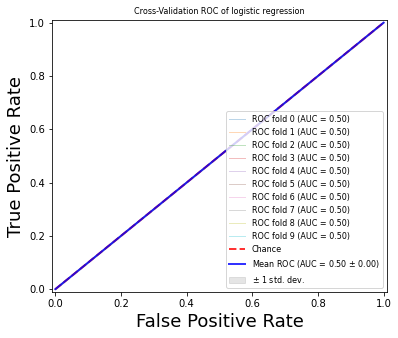

In [9]:
#ROC_AUC


kf = KFold(n_splits=10,shuffle=True)
tprs = []
aucs = []
fpr_lst=list()
tpr_lst=list()
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(6,5))
i = 0
for _ , _ in kf.split(X,y):
    # Compute ROC curve and area the curve
    #fpr, tpr, thresholds = roc_curve(Y_test_lst[i],res_probas_[i][:,1] )
    fpr, tpr, thresholds = roc_curve(Y_test_lst[i],pred_values_lst[i])
    fpr_lst.append(mean(fpr))
    tpr_lst.append(mean(tpr))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of logistic regression',fontsize=8)
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [10]:
#recall/TPR
import warnings
warnings.filterwarnings('ignore') 

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_recall = cross_val_score(model,X, y, scoring='recall', cv=cv)

print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))

scores_recall: 0.000 (0.000)


In [11]:
# accracy
import warnings
warnings.filterwarnings('ignore') 

cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.991 (0.002)


In [12]:
#precision
import warnings
warnings.filterwarnings('ignore') 

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.000 (0.000)
